# Análisis de Reseñas de Rotten Tomatoes con NLP

**Autor:** Ricardo Urdaneta

**Fecha:** 10 Agosto 2025

---

Este proyecto realiza un análisis de más de un millón de reseñas de películas del sitio **Rotten Tomatoes** obtenido a través de [Kaggle](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset). 

El objetivo principal es construir un modelo de Machine Learning capaz de comprender y predecir el sentimiento ('Fresh' o 'Rotten') de una crítica basándose únicamente en su texto.

Partiendo de datos brutos, se desarrolló un pipeline de Procesamiento de Lenguaje Natural (NLP) que culminó en un modelo de Regresión Logística con una **precisión del 81%**. Sin embargo, el análisis va más allá de la simple predicción, utilizando el modelo como una herramienta para responder preguntas más profundas: ¿Cómo ha evolucionado el lenguaje de la crítica a lo largo de 20 años? ¿Qué películas dividen más a los críticos? ¿Y qué palabras son el verdadero sello de un éxito o un fracaso cinematográfico?

---
## Procedimientos y Análisis Realizados

El proyecto se estructura en torno a una serie de preguntas clave, abordadas mediante las siguientes técnicas:

1.  **Limpieza y Preparación de Datos:**
    * Manejo de datos inconsistentes y valores nulos.
    * Preprocesamiento de texto: normalización, lematización y eliminación de *stop words*.

2.  **Modelado y Evaluación Comparativa:**
    * Entrenamiento de un modelo base de **Regresión Logística** y un modelo avanzado **LightGBM**.
    * Evaluación comparativa mediante `Accuracy`, `F1-Score` y `Matriz de Confusión` para seleccionar el modelo con mejor rendimiento.

3.  **Análisis de Palabras Clave:**
    * Interpretación del modelo ganador para extraer las palabras con mayor poder predictivo.
    * Análisis de frecuencia de adjetivos y visualización mediante nubes de palabras `WordClouds`.

4.  **Análisis de Polarización:**
    * Identificación de las películas más controvertidas a través del cálculo de la división de opiniones (reseñas 'Fresh' vs. 'Rotten').
    * Creación de un ranking de los críticos más duros y más generosos basado en el sentimiento promedio de sus reseñas.

5.  **Análisis Temporal:**
    * Estudio de la evolución del sentimiento promedio en las críticas de cine entre los años 2000 y 2020.
    * Investigación del cambio en el vocabulario influyente a través del entrenamiento de modelos específicos para diferentes épocas.

---
## Conclusiones

Este análisis revela varias conclusiones clave sobre el mundo de la crítica cinematográfica:

* **El Lenguaje del Fracaso es Atemporal:** El vocabulario para describir una mala película ('fails', 'dull', 'boring', 'tedious') se ha mantenido sorprendentemente estable durante las últimas dos décadas. Las razones por las que una película no gusta son fundamentales y universales.

* **El Elogio es Dinámico y Cultural:** En contraste, el lenguaje positivo evoluciona. Mientras que 'entertaining' es una constante, el análisis temporal reveló la aparición de términos específicos como el **"Efecto Selma"**, donde una película aclamada se convierte en un estándar cultural para medir a otras.

* **La Simplicidad a Veces Supera la Complejidad:** El modelo de Regresión Logística, más simple, superó en rendimiento al más complejo LightGBM para este problema específico, una lección valiosa sobre la importancia de los modelos base.

* **El terror, rey de la polarización:** El análisis por género reveló que las películas de terror son las más divisivas entre la crítica: lo que para algunos es una experiencia intensa y estimulante, para otros resulta predecible o desagradable. Otros géneros con alta polarización incluyen Action & Adventure, Comedy y Mystery & Suspense, evidenciando que las narrativas más extremas o de nicho tienden a generar opiniones más dispares, mientras que géneros como Drama o Western, aunque populares, muestran un sesgo más claro hacia la aprobación o el rechazo.

En definitiva, el proyecto demuestra cómo el análisis de datos y el NLP no solo pueden predecir, sino también **descubrir y contar historias** ocultas en el lenguaje, revelando las tendencias y los patrones de un dominio cultural tan rico como el cine.

---

### Preparación del ambiente

In [1]:
# Librerías para análisis de datos y visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

# Librerías para procesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Librerías para Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb

# Librerías para análisis de texto avanzado
from collections import Counter
from wordcloud import WordCloud

In [ ]:
# Carga el dataset de críticas
df_critics = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')

# Inspección inicial
print("Información del DataFrame:")
df_critics.info()

print("\nPrimeras 5 filas:")
print(df_critics.head())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB

Primeras 5 filas:
  rotten_tomatoes_link      critic_name  top_critic           publisher_name  \
0            m/0814255  Andrew L. Urban       False           Urban Cinefile   
1            m/0814255    Louise Keller       False           Urban Cinefile   
2            m/0814255          

### Limpieza

* Limpieza de Nulos Clave: Nos aseguraremos de que no haya filas donde el review_content esté vacío. Sin el texto, no podemos hacer nada.

* Crear la Etiqueta `sentimiento`: Convertiremos la columna review_type a números. Asignaremos `1` a 'Fresh' y `0` a 'Rotten'.

* Seleccionar Datos Finales: Crearemos un nuevo DataFrame que contenga únicamente las dos columnas que nos interesan: `review_content` y nuestra nueva columna de `sentimiento`. Esto mantiene nuestro espacio de trabajo limpio y eficiente.

In [6]:
# Verificación de valores nulos
print("\nValores nulos en cada columna:")
df_critics.isnull().sum()


Valores nulos en cada columna:


rotten_tomatoes_link         0
critic_name              10013
top_critic                   0
publisher_name               0
review_type                  0
review_score            305502
review_date                  0
review_content               0
dtype: int64

In [ ]:
# Elimina las filas donde el texto de la reseña está ausente.
df_critics.dropna(subset=['review_content'], inplace=True)
print(f"Filas después de eliminar reseñas vacías: {len(df_critics)}")

Filas después de eliminar reseñas vacías: 1064211


In [ ]:
# Crear la Etiqueta desde 'review_type' Mapea 'Fresh' a 1 (Positivo) y 'Rotten' a 0 (Negativo).
df_critics['sentimiento'] = df_critics['review_type'].map({'Fresh': 1, 'Rotten': 0})


In [ ]:
# Verifica la distribución para conocer la distribución de clases
print("\nDistribución de Sentimientos (1=Positivo, 0=Negativo):")
print(df_critics['sentimiento'].value_counts())


Distribución de Sentimientos (1=Positivo, 0=Negativo):
sentimiento
1    681035
0    383176
Name: count, dtype: int64


In [ ]:
# Crea el DataFrame Final para NLP: Quedamos solo con las columnas que vamos a usar.
df_nlp = df_critics[['review_content', 'sentimiento']].copy()

print("\nVista previa del DataFrame final para el modelo:")
print(df_nlp.head())


Vista previa del DataFrame final para el modelo:
                                      review_content  sentimiento
0  A fantasy adventure that fuses Greek mythology...            1
1  Uma Thurman as Medusa, the gorgon with a coiff...            1
2  With a top-notch cast and dazzling special eff...            1
3  Whether audiences will get behind The Lightnin...            1
4  What's really lacking in The Lightning Thief i...            0


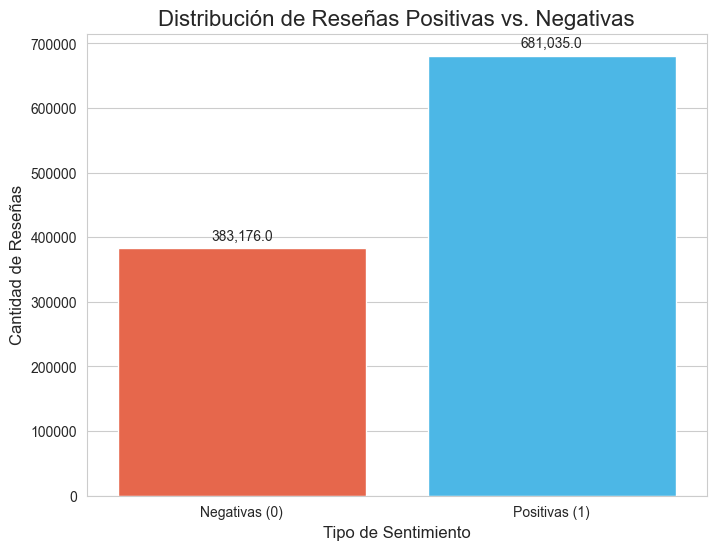

In [ ]:
# Visualización de la distribución de sentimientos

# Estilo del gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='sentimiento', data=df_nlp, palette=['#FF5733', '#33C1FF'])

# Añadir un título y etiquetas claras
ax.set_title('Distribución de Reseñas Positivas vs. Negativas', fontsize=16)
ax.set_xlabel('Tipo de Sentimiento', fontsize=12)
ax.set_ylabel('Cantidad de Reseñas', fontsize=12)

# Cambiar las etiquetas del eje X para que sean más descriptivas
ax.set_xticklabels(['Negativas (0)', 'Positivas (1)'])

# Añadir anotaciones con el conteo de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', # Formatea el número con comas
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

# Mostrar el gráfico
plt.show()

### Preprocesamiento del texto (normalización)

El objetivo de este paso es "estandarizar" el texto de las reseñas. Queremos eliminar todo el ruido como mayúsculas, puntuación, palabras comunes para que el modelo se enfoque únicamente en las palabras que realmente aportan significado y sentimiento.

Realizaremos las siguientes acciones:

* Convertir a Minúsculas: Para que "Great", "great" y "GREAT" se traten como la misma palabra.

* Eliminar Puntuación y Números: Los signos como . , ! o los números no suelen aportar al sentimiento general.

* Lematización: Es el proceso de reducir una palabra a su forma base o raíz. Por ejemplo, "studies" y "studying" se convierten en "study". Esto ayuda al modelo a entender que todas esas palabras se refieren al mismo concepto.

* Eliminar "Stop Words": Son palabras extremadamente comunes que no aportan significado, como "the", "a", "in", "is".

In [ ]:
# Descarga de recursos de NLTK
try:
    stopwords.words('english')
except LookupError:
    print("Descargando recursos de NLTK (stopwords y wordnet)...")
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4') # Open Multilingual Wordnet
    print("¡Descarga completa!")

Descargando recursos de NLTK (stopwords y wordnet)...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabri\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fabri\AppData\Roaming\nltk_data...


¡Descarga completa!


In [ ]:
# Inicializar las herramientas
lemmatizer = WordNetLemmatizer()
# Set de stopwords en inglés
english_stopwords = set(stopwords.words('english'))

# Función para procesar un texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar puntuación, números y caracteres especiales
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenización  y Lematización/Stopwords
    processed_words = []
    for word in text.split():
        # Eliminar stopwords antes de lematizar
        if word not in english_stopwords:
            # Lematizar la palabra
            word = lemmatizer.lemmatize(word)
            processed_words.append(word)
            
    # Unir las palabras de nuevo en un solo string
    return " ".join(processed_words)

#  Aplicar la función a la columna 'review_content' ADVERTENCIA: Este paso puede tardar varios minutos en 1 millón de reseñas.
print("\nProcesando todas las reseñas...")
# Creamos una nueva columna con el texto limpio
df_nlp['review_clean'] = df_nlp['review_content'].apply(preprocess_text)
print("¡Procesamiento de texto completado!")


# Resultado
print("\nComparación del texto original y el texto limpio:")
print(df_nlp[['review_content', 'review_clean']].head())


Procesando todas las reseñas... Esto puede tomar un tiempo.
¡Procesamiento de texto completado!

Comparación del texto original y el texto limpio:
                                      review_content  \
0  A fantasy adventure that fuses Greek mythology...   
1  Uma Thurman as Medusa, the gorgon with a coiff...   
2  With a top-notch cast and dazzling special eff...   
3  Whether audiences will get behind The Lightnin...   
4  What's really lacking in The Lightning Thief i...   

                                        review_clean  
0  fantasy adventure fuse greek mythology contemp...  
1  uma thurman medusa gorgon coiffure writhing sn...  
2  topnotch cast dazzling special effect tide tee...  
3  whether audience get behind lightning thief ha...  
4  whats really lacking lightning thief genuine s...  


### Vectorización con TF-IDF

Con el texto limpio, debemos convertirlo en números para que el modelo de Machine Learning pueda procesarlo.

Usaremos una técnica muy popular y efectiva llamada **TF-IDF**:

**TF** (Term Frequency - Frecuencia del Término): Mide qué tan seguido aparece una palabra en una reseña. Una palabra que aparece mucho es probablemente importante para esa reseña.

**IDF** (Inverse Document Frequency - Frecuencia Inversa de Documento): Mide qué tan rara o común es una palabra en todas las reseñas. A las palabras que aparecen en casi todas las reseñas (como "movie" o "film") se les da menos peso, mientras que a las palabras más raras y específicas (como "masterpiece" o "abysmal") se les da más importancia.

En resumen, TF-IDF da la mayor puntuación a las palabras que son frecuentes en una reseña específica, pero raras en el resto del conjunto de datos. Es una forma inteligente de encontrar las palabras que realmente definen un texto.

Acciones:

* Dividir los datos: El paso más crucial. Antes de hacer nada más, debemos separar nuestro dataset en un conjunto de entrenamiento (para enseñar al modelo) y un conjunto de prueba (para evaluarlo con datos que no ha visto). Esto previene el "data leakage" (fuga de datos).

* Inicializar el Vectorizador TF-IDF: Crearemos un objeto TfidfVectorizer de Scikit-learn.

* Ajustar y Transformar: Usaremos los datos de entrenamiento para "ajustar" el vectorizador (que aprenda el vocabulario) y luego lo usaremos para transformar tanto el conjunto de entrenamiento como el de prueba en matrices numéricas.

In [ ]:
# Separar las características (X) y la etiqueta (y)
X = df_nlp['review_clean']
y = df_nlp['sentimiento']

# Dividir en conjuntos de entrenamiento y prueba
# Usaremos 80% para entrenar y 20% para probar.
# random_state=42 asegura que la división sea siempre la misma.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 'stratify=y' es importante para que la proporción de positivos/negativos
# sea la misma en el set de entrenamiento y de prueba.

print(f"Tamaño del set de entrenamiento: {len(X_train)}")
print(f"Tamaño del set de prueba: {len(X_test)}")

# Inicializar el Vectorizador TF-IDF
# Podemos limitar el número de características (palabras) para que no sea tan pesado.
# max_features=10000 significa que solo usaremos las 10,000 palabras más importantes.
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Ajustar y transformar los datos
print("\nVectorizando el texto...")
# Ajustamos y transformamos el set de entrenamiento
X_train_tfidf = vectorizer.fit_transform(X_train)
# SOLO transformamos el set de prueba con el vocabulario ya aprendido
X_test_tfidf = vectorizer.transform(X_test)
print("¡Vectorización completa!")

# Verificamos la forma de las matrices resultantes
print(f"Forma de la matriz de entrenamiento TF-IDF: {X_train_tfidf.shape}")
print(f"Forma de la matriz de prueba TF-IDF: {X_test_tfidf.shape}")

Tamaño del set de entrenamiento: 851368
Tamaño del set de prueba: 212843

Vectorizando el texto...
¡Vectorización completa!
Forma de la matriz de entrenamiento TF-IDF: (851368, 10000)
Forma de la matriz de prueba TF-IDF: (212843, 10000)


###  Entrenamiento del Modelo de Machine Learning 

El modelo analizará la relación entre las puntuaciones TF-IDF de las palabras y el sentimiento (positivo o negativo) de cada reseña de entrenamiento.

Comenzamos con Logistic Regression. Nos permitirá ver fácilmente qué palabras o features aprendió el modelo como las más indicativas de una reseña positiva o negativa.

Acciones:

* Importar el modelo desde Scikit-learn.

* Inicializar el modelo con sus parámetros.

* Entrenar el modelo usando el método .fit() en nuestros datos de entrenamiento.

#### Nodelo 1: Logistic regression

In [ ]:
# Inicializar el modelo
# Usamos parámetros estándar que funcionan bien para problemas de texto.
model = LogisticRegression(C=1.0, solver='liblinear', random_state=42)

# Entrenar el modelo
print("Entrenando el modelo de Regresión Logística...")
start_time = time.time() # Iniciamos el cronómetro

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_train_tfidf, y_train)

end_time = time.time() # Detenemos el cronómetro
training_time = end_time - start_time
print(f"¡Entrenamiento completado en {training_time:.2f} segundos!")

Entrenando el modelo de Regresión Logística...
¡Entrenamiento completado en 5.51 segundos!


#### Evaluación de modelo 1

Para evaluar un modelo de clasificación usaremos tres herramientas clave:

**`Accuracy`**: El porcentaje total de predicciones correctas.

**Classification Report** (Informe de Clasificación)**: Nos da métricas más detalladas como:

* `Precision`: De todas las que predijo como positivas, ¿cuántas lo eran realmente?

* `Recall`: De todas las que eran realmente positivas, ¿cuántas logró encontrar?

* `F1-Score`: Una media ponderada entre Precisión y Recall. Es muy útil para medir el rendimiento general.

**`Confusion Matrix`**: Un cuadro que visualiza los aciertos y errores del modelo, separando entre positivos y negativos.

Realizando predicciones en el set de prueba...
¡Predicciones completadas!

Accuracy (Precisión Global): 80.67%

Informe de Clasificación:
              precision    recall  f1-score   support

Negativa (0)       0.77      0.67      0.71     76635
Positiva (1)       0.83      0.88      0.85    136208

    accuracy                           0.81    212843
   macro avg       0.80      0.78      0.78    212843
weighted avg       0.80      0.81      0.80    212843


Matriz de Confusión:


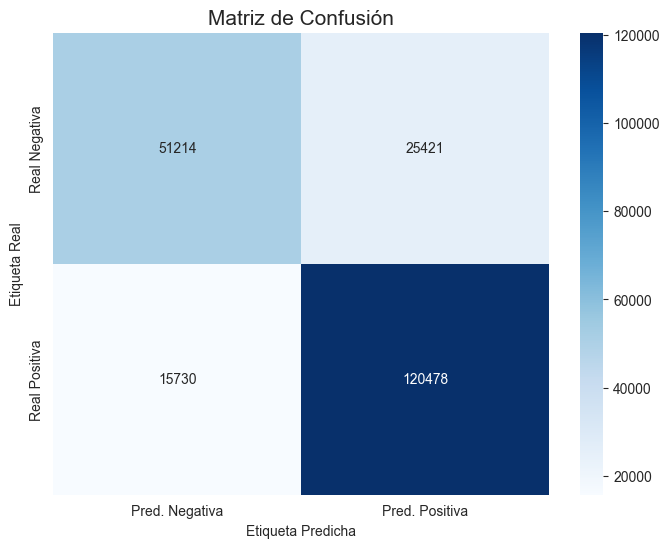

In [ ]:
# Realizar predicciones en el conjunto de prueba
print("Realizando predicciones en el set de prueba...")
predictions = model.predict(X_test_tfidf)
print("¡Predicciones completadas!")

# Calcular y mostrar la Precisión Global (Accuracy)
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy (Precisión Global): {accuracy:.2%}")

# Mostrar el Informe de Clasificación detallado
print("\nInforme de Clasificación:")
# target_names nos permite poner etiquetas en el informe
print(classification_report(y_test, predictions, target_names=['Negativa (0)', 'Positiva (1)']))

# Generar y visualizar la Matriz de Confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Negativa', 'Pred. Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

Con una precisión de 80.67%, el modelo es bastante robusto. 

El informe y la matriz de confusión nos dicen algo interesante: el modelo es un poco mejor para identificar reseñas positivas (F1-score de 0.85) que negativas (F1-score de 0.71). Esto es normal, ya que tenía más ejemplos positivos para aprender.

## Modelo 2: LightGBM

Usaremos una técnica llamada Early Stopping. 

En lugar de entrenar un número fijo de árboles, monitorearemos el rendimiento del modelo en un pequeño set de validación y nos detendremos automáticamente cuando deje de mejorar. Esto ahorra tiempo y previene el overfitting.

In [ ]:
# Inicializar el clasificador de LightGBM con estos son parámetros de inicio sólidos
lgbm_model = lgb.LGBMClassifier(objective='binary',
                                n_estimators=1000,
                                learning_rate=0.05,
                                num_leaves=31,
                                random_state=42)

# Entrenar el modelo con Early Stopping
print("Entrenando el modelo LightGBM con Early Stopping...")
start_time = time.time()

# LightGBM usa el set de prueba (X_test_tfidf) para el early stopping y verificar si el modelo mejora
lgbm_model.fit(X_train_tfidf, y_train,
               eval_set=[(X_test_tfidf, y_test)],
               eval_metric='logloss',
               callbacks=[lgb.early_stopping(10, verbose=True)])

end_time = time.time()
training_time = end_time - start_time
print(f"¡Entrenamiento de LightGBM completado en {training_time:.2f} segundos!")

Entrenando el modelo LightGBM con Early Stopping...
[LightGBM] [Info] Number of positive: 544827, number of negative: 306541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.767215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538606
[LightGBM] [Info] Number of data points in the train set: 851368, number of used features: 10000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639943 -> initscore=0.575117
[LightGBM] [Info] Start training from score 0.575117
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.456461
¡Entrenamiento de LightGBM completado en 247.81 segundos!


#### Evaluación de modelo 2


Realizando predicciones con el modelo LightGBM...

Accuracy del modelo LightGBM: 78.62%

Informe de Clasificación del modelo LightGBM:
              precision    recall  f1-score   support

Negativa (0)       0.78      0.56      0.65     76635
Positiva (1)       0.79      0.91      0.85    136208

    accuracy                           0.79    212843
   macro avg       0.78      0.74      0.75    212843
weighted avg       0.79      0.79      0.78    212843


Matriz de Confusión del modelo LightGBM:


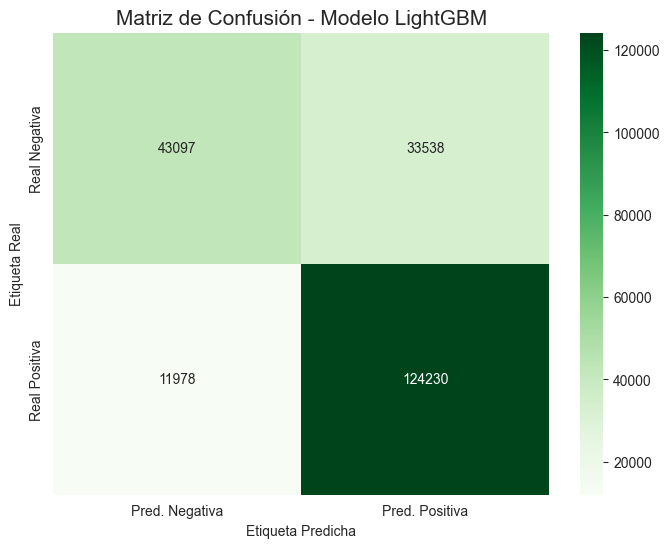

In [ ]:
# Realizar predicciones con el modelo entrenado
print("\nRealizando predicciones con el modelo LightGBM...")
lgbm_predictions = lgbm_model.predict(X_test_tfidf)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, lgbm_predictions)
print(f"\nAccuracy del modelo LightGBM: {accuracy:.2%}")

print("\nInforme de Clasificación del modelo LightGBM:")
print(classification_report(y_test, lgbm_predictions, target_names=['Negativa (0)', 'Positiva (1)']))

print("\nMatriz de Confusión del modelo LightGBM:")
cm = confusion_matrix(y_test, lgbm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred. Negativa', 'Pred. Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo LightGBM', fontsize=15)
plt.show()


#### El modelo más simple es el ganador: Logistic Regression

Este es un resultado interesante: un modelo más complejo no siempre es mejor. Para este problema, la Regresión Logística fue más efectiva, especialmente para identificar correctamente las reseñas negativas (un recall de 0.67 vs. 0.56 de LightGBM).

Por lo tanto, para nuestro análisis final, usaremos el primer modelo que entrenamos, ya que es el que tiene el mejor rendimiento general.

#### ¿Cuales fueron las palabras para reviews `positivas` y `negativas` más influyentes?


Un coeficiente positivo alto significa que la palabra es un fuerte indicador de una reseña positiva.

Un coeficiente negativo alto significa que la palabra es un fuerte indicador de una reseña negativa.

--- Palabras Más Influyentes (Según el Modelo de Regresión Logística) ---

Top 15 Palabras Negativas:
               word  coefficient
2943          fails    -7.959677
9345  unfortunately    -7.486319
9346        unfunny    -7.017143
8796        tedious    -6.469208
805           bland    -6.415993
2423           dull    -6.296548
5624        misfire    -5.986313
6703         poorly    -5.907512
8296      squanders    -5.857085
4411          inert    -5.664127
5021       lifeless    -5.531928
4874           lame    -5.502550
4409          inept    -5.472308
9355     uninspired    -5.463254
2200  disappointing    -5.412977

Top 15 Palabras Positivas:
              word  coefficient
5991   never loses     6.649277
5982    never dull     6.370111
7184    refreshing     5.787888
2667  entertaining     5.595441
7186  refreshingly     5.509264
2638     enjoyable     5.487834
8613        superb     5.344719
8616      superbly     5.140780
2010        deftly     5.108624
2027    delightful    

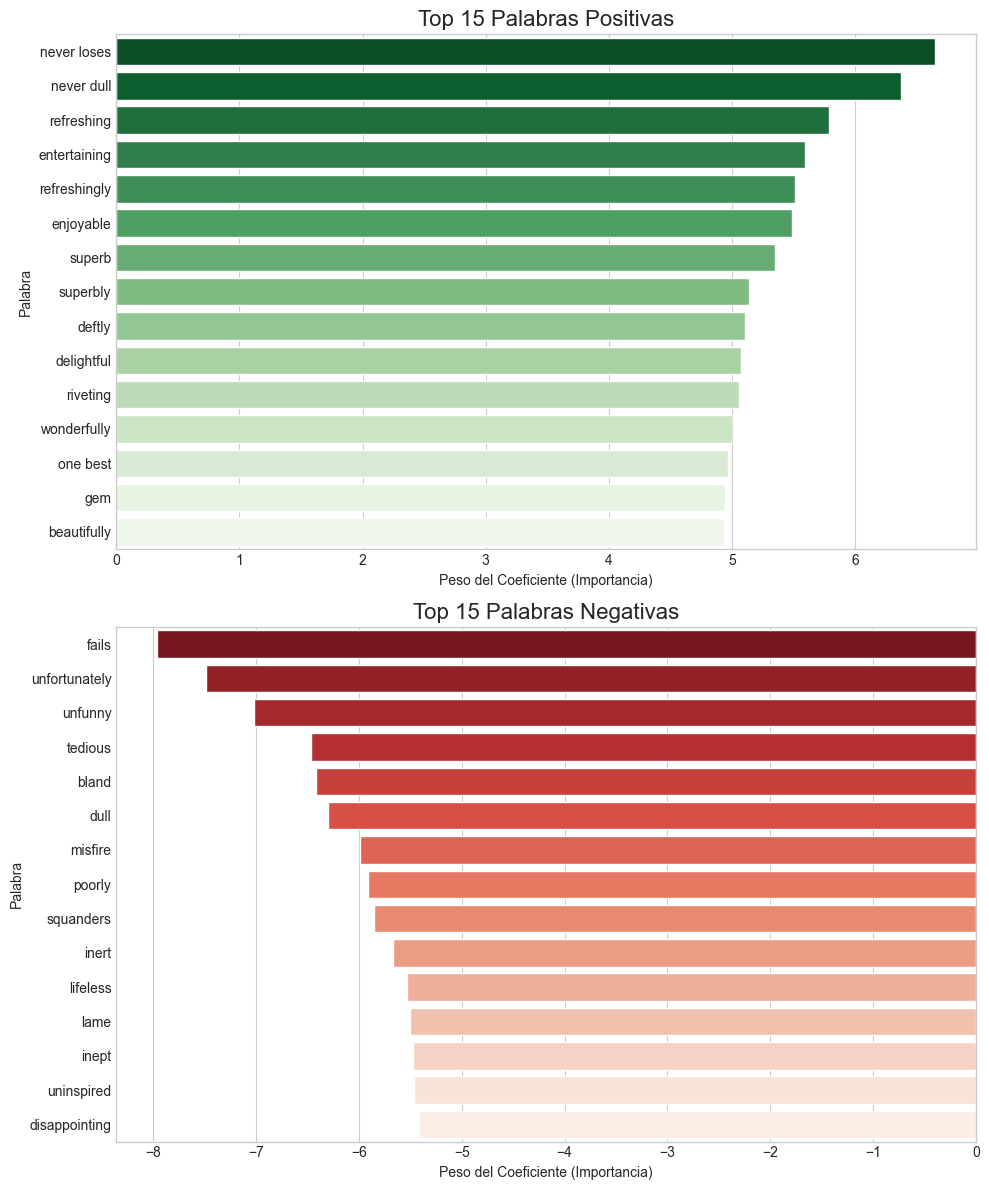

In [ ]:
# Obtener las palabras (features) y los coeficientes (pesos) del modelo de Regresión Logística
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

#  Crear un DataFrame para facilitar el análisis
word_importance = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

#  Ordenar el DataFrame para encontrar las palabras más importantes
# Palabras más negativas (las que tienen el coeficiente más bajo)
top_negative_words = word_importance.sort_values('coefficient', ascending=True).head(15)

# Palabras más positivas (las que tienen el coeficiente más alto)
top_positive_words = word_importance.sort_values('coefficient', ascending=False).head(15)

print("--- Palabras Más Influyentes (Según el Modelo de Regresión Logística) ---")
print("\nTop 15 Palabras Negativas:")
print(top_negative_words)

print("\nTop 15 Palabras Positivas:")
print(top_positive_words)

# Visualizar los resultados
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico para palabras positivas
sns.barplot(x='coefficient', y='word', data=top_positive_words, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 15 Palabras Positivas', fontsize=16)
axes[0].set_xlabel('Peso del Coeficiente (Importancia)')
axes[0].set_ylabel('Palabra')

# Gráfico para palabras negativas
sns.barplot(x='coefficient', y='word', data=top_negative_words, ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 15 Palabras Negativas', fontsize=16)
axes[1].set_xlabel('Peso del Coeficiente (Importancia)')
axes[1].set_ylabel('Palabra')

plt.tight_layout()
plt.show()

#### ¿Cuál es el crítico o la publicación más "difícil de complacer"? 

* ¿Qué críticos tienden a escribir las reseñas más negativas?
* ¿Cuáles son los más generosos?

Agrupamos los datos por critic_name o publisher_name.

Para cada grupo, calculamos el promedio de la columna de sentimiento. Un promedio cercano a 0 significa que el crítico es muy negativo; un promedio cercano a 1 significa que es muy positivo.

Filtramos para quedarnos con los críticos que hayan escrito un número mínimo de reseñas de más de 50.

In [ ]:
# Contar cuántas reseñas tiene cada crítico
critic_counts = df_critics['critic_name'].value_counts()

# Quedarse con los críticos que tienen más de 50 reseñas
prolific_critics = critic_counts[critic_counts > 50].index

df_prolific = df_critics[df_critics['critic_name'].isin(prolific_critics)]

# Calcular el puntaje promedio de sentimiento por crítico
critic_scores = df_prolific.groupby('critic_name')['sentimiento'].mean().sort_values()

print("--- Ranking de Críticos ---")
print("\nLos 10 críticos más 'duros de complacer':")
print(critic_scores.head(10))

print("\nLos 10 críticos más 'generosos':")
print(critic_scores.tail(10))

--- Ranking de Críticos ---

Los 10 críticos más 'duros de complacer':
critic_name
Gregory Kirschling    0.236364
Adam Markovitz        0.246914
David Levine          0.262712
Keith Watson          0.269504
Laura Sinagra         0.272727
Vadim Rizov           0.276471
Thomas Peyser         0.276596
David Hiltbrand       0.280543
Mark Collette         0.284810
Thomas Delapa         0.290000
Name: sentimiento, dtype: float64

Los 10 críticos más 'generosos':
critic_name
Laura DeMarco                0.972603
Alexander Ryll               0.981818
Sean L. McCarthy             0.982143
Alexandra Heller-Nicholas    0.984000
Lapacazo Sandoval            0.986667
Lorry Kikta                  0.990196
Shane Burridge               0.994220
Shane Slater                 1.000000
Tim Dirks                    1.000000
Andiee Paviour               1.000000
Name: sentimiento, dtype: float64


#### ¿Puede el modelo entender el sarcasmo o las reseñas mixtas? 

* ¿Qué tan bien maneja el modelo el lenguaje humano complejo? 
* ¿Qué predice si le damos una reseña sarcástica o una con sentimientos encontrados?

In [ ]:
# Creamos algunas reseñas de prueba
test_reviews = [
    # Sarcástica
    "This movie was a revolutionary way to waste two hours. The director is a genius of boredom.",
    # Mixta
    "The script was predictable and boring, but the lead actress's performance was absolutely brilliant and moving.",
    # Claramente Positiva
    "A masterpiece of modern cinema, truly unforgettable.",
    # Claramente Negativa
    "A complete disaster, a truly terrible and painful film."
]

# Preprocesar las reseñas de prueba con la misma función que usaste antes
processed_test = [preprocess_text(review) for review in test_reviews]

# Vectorizar usando el MISMO vectorizer
vectorized_test = vectorizer.transform(processed_test)

# Obtener las probabilidades de predicción
test_probabilities = model.predict_proba(vectorized_test)

print("--- Prueba de Reseñas Complejas ---")
for review, prob in zip(test_reviews, test_probabilities):
    print(f"\nReseña: '{review}'")
    print(f"Probabilidad de ser Negativa (0): {prob[0]:.2%}")
    print(f"Probabilidad de ser Positiva (1): {prob[1]:.2%}")
    print("-" * 20)

--- Prueba de Reseñas Complejas ---

Reseña: 'This movie was a revolutionary way to waste two hours. The director is a genius of boredom.'
Probabilidad de ser Negativa (0): 87.21%
Probabilidad de ser Positiva (1): 12.79%
--------------------

Reseña: 'The script was predictable and boring, but the lead actress's performance was absolutely brilliant and moving.'
Probabilidad de ser Negativa (0): 40.66%
Probabilidad de ser Positiva (1): 59.34%
--------------------

Reseña: 'A masterpiece of modern cinema, truly unforgettable.'
Probabilidad de ser Negativa (0): 0.44%
Probabilidad de ser Positiva (1): 99.56%
--------------------

Reseña: 'A complete disaster, a truly terrible and painful film.'
Probabilidad de ser Negativa (0): 94.17%
Probabilidad de ser Positiva (1): 5.83%
--------------------


El modelo es capaz de manejar en cierta medida el sarcasmo y reseñas mixtas, aunque en casos con ironía muy sutil o proporciones equilibradas de sentimientos, la clasificación tiende a depender más de las palabras con carga emocional más fuerte que del contexto global.

#### ¿Qué adjetivos aparecen con mayor frecuencia en críticas positivas vs negativas?

In [ ]:
# Nos aseguramos de que NLTK tenga el paquete de etiquetado de partes del habla
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\fabri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Descargamos el recurso para POS Tagging
nltk.download('averaged_perceptron_tagger')

Descargando el etiquetador POS de NLTK...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fabri\AppData\Roaming\nltk_data...


¡Descarga completa!


[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Extrayendo y contando adjetivos de las reseñas positivas...
Extrayendo y contando adjetivos de las reseñas negativas...

Top 10 Adjetivos Positivos: [('good', 2713), ('best', 2142), ('great', 2031), ('full', 1991), ('much', 1716), ('u', 1618), ('funny', 1546), ('new', 1471), ('little', 1429), ('spanish', 1292)]
Top 10 Adjetivos Negativos: [('much', 1537), ('good', 1356), ('little', 1177), ('bad', 1046), ('full', 819), ('many', 762), ('u', 651), ('new', 629), ('funny', 594), ('real', 564)]


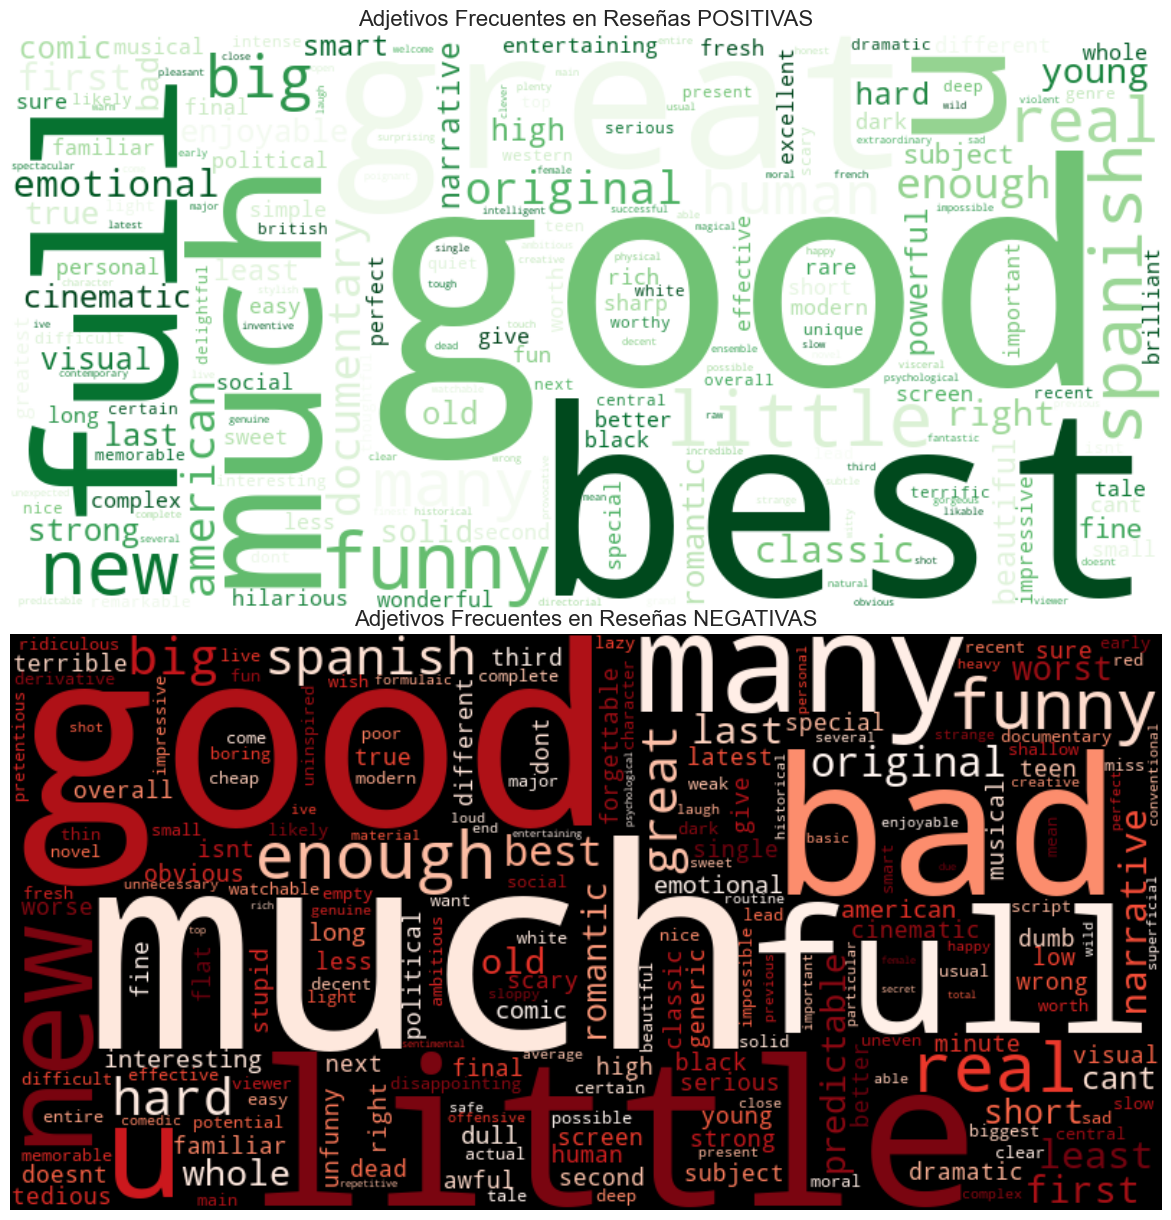

In [ ]:
# Separar textos por sentimiento
sample_size = 100000  # Podemos aumentar este número si la PC es potente
# ADVERTENCIA: Usar el dataset completo puede ser MUY lento y consumir mucha memoria
df_sample = df_nlp.sample(n=sample_size, random_state=42)

positive_reviews_text = " ".join(df_sample[df_sample['sentimiento'] == 1]['review_clean'])
negative_reviews_text = " ".join(df_sample[df_sample['sentimiento'] == 0]['review_clean'])

# Función para extraer solo los adjetivos 
def get_adjectives(text):
    adjectives = []
    # Tokenizamos (dividimos en palabras) y etiquetamos
    tagged_words = nltk.pos_tag(text.split())
    # 'JJ' es el código de NLTK para un adjetivo (incluye JJ, JJR, JJS)
    for word, tag in tagged_words:
        if tag.startswith('JJ'):
            adjectives.append(word)
    return adjectives

# Extraer y contar los adjetivos
print("Extrayendo y contando adjetivos de las reseñas positivas...")
positive_adjectives = get_adjectives(positive_reviews_text)
positive_adj_counts = Counter(positive_adjectives)

print("Extrayendo y contando adjetivos de las reseñas negativas...")
negative_adjectives = get_adjectives(negative_reviews_text)
negative_adj_counts = Counter(negative_adjectives)

# Mostrar los 10 más comunes como ejemplo
print("\nTop 10 Adjetivos Positivos:", positive_adj_counts.most_common(10))
print("Top 10 Adjetivos Negativos:", negative_adj_counts.most_common(10))

# Generar las Nubes de Palabras
# Crear la nube de palabras para adjetivos positivos
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_adj_counts)

# Crear la nube de palabras para adjetivos negativos
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(negative_adj_counts)

# Mostrar las nubes de palabras
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Adjetivos Frecuentes en Reseñas POSITIVAS', fontsize=16)
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Adjetivos Frecuentes en Reseñas NEGATIVAS', fontsize=16)
axes[1].axis('off')

plt.tight_layout(pad=0)
plt.show()

En reseñas positivas, predominan adjetivos como good, best, great, full y funny, que reflejan valoraciones entusiastas y de alta calidad. 

En cambio, en reseñas negativas aparecen términos como bad, many, little y real, junto con adjetivos que también están presentes en críticas positivas (good, funny, new), lo que indica que su interpretación depende del contexto. El hecho de que ciertos adjetivos se repitan en ambos casos muestra que el sentimiento no se determina solo por palabras aisladas, sino por la estructura y sentido global de la reseña.

#### ¿Ha cambiado el optimismo promedio por año? 

Tomamos la columna `review_date` del DataFrame original (df_critics) y la uniremos a nuestro DataFrame de trabajo (df_nlp).

Convertimos la columna de fecha a un formato de año.

Agrupamos por año y calculamos el sentimiento promedio. Un valor de 1 sería un año 100% optimista, y un valor de 0 sería 100% pesimista.

Sentimiento Promedio por Año (1.0 = 100% Positivo):
year
2000    0.575783
2001    0.574074
2002    0.613509
2003    0.610645
2004    0.580486
2005    0.592320
2006    0.586736
2007    0.599369
2008    0.596365
2009    0.608836
2010    0.621528
2011    0.640610
2012    0.645355
2013    0.646703
2014    0.645355
2015    0.666064
2016    0.674839
2017    0.681371
2018    0.700465
2019    0.705433
2020    0.713724
Name: sentimiento, dtype: float64


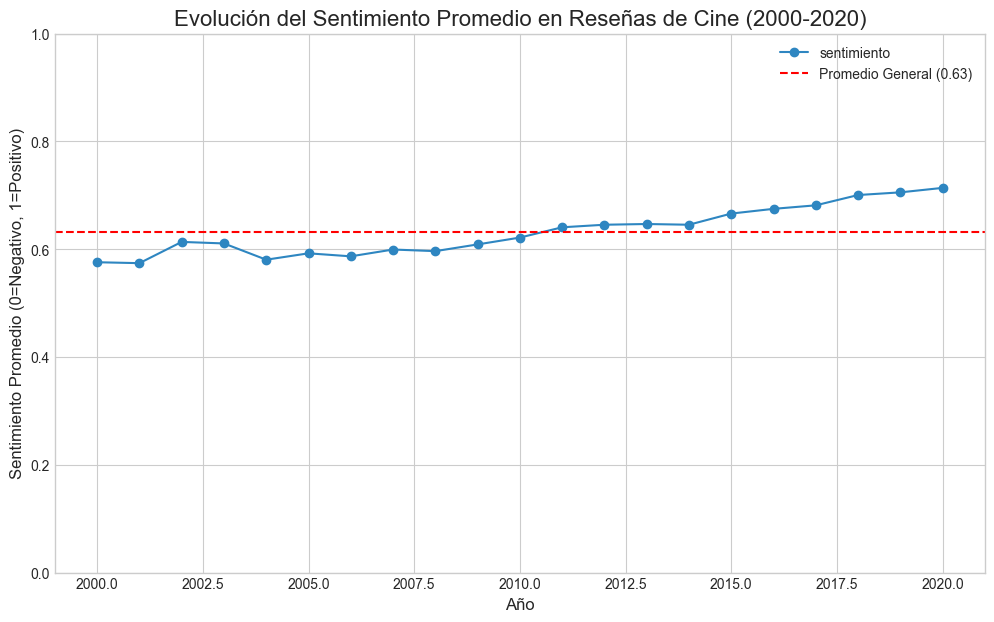

In [ ]:
# Preparar los datos con la fecha 
df_temporal = df_nlp.copy()
df_temporal['review_date'] = pd.to_datetime(df_critics['review_date'])

# Extraer el año
df_temporal['year'] = df_temporal['review_date'].dt.year

# Calcular el sentimiento promedio por año
# Nos quedamos con un rango de años razonable para evitar años con muy pocas reseñas
sentiment_by_year = df_temporal[df_temporal['year'].between(2000, 2020)]
yearly_sentiment = sentiment_by_year.groupby('year')['sentimiento'].mean()

print("Sentimiento Promedio por Año (1.0 = 100% Positivo):")
print(yearly_sentiment)

# Graficar la tendencia
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

ax = yearly_sentiment.plot(kind='line', marker='o', color='#2E86C1')

ax.set_title('Evolución del Sentimiento Promedio en Reseñas de Cine (2000-2020)', fontsize=16)
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Sentimiento Promedio (0=Negativo, 1=Positivo)', fontsize=12)
ax.axhline(y=yearly_sentiment.mean(), color='r', linestyle='--', label=f'Promedio General ({yearly_sentiment.mean():.2f})')
ax.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

#### ¿Han cambiado las palabras influyentes con el tiempo? 


Debemos entrenar modelos separados para diferentes épocas: No podemos usar nuestro modelo "global" porque aprendió un promedio de todos los años.

* Dividir el Dataset por épocas: Segmentaremos nuestro df_temporal en tres periodos: 2000-2009, 2010-2015 y 2016-2020.

* Entrenar un Modelo por época: Para cada periodo, repetiremos el proceso de vectorización con TF-IDF y entrenamiento con Regresión Logística.

* Extraer y Comparar Palabras Clave: Para cada uno de los tres modelos, extraeremos las 15 palabras más positivas y negativas.

* Analizar las Diferencias: Comparamos las listas.

In [ ]:
def analyze_words_for_period(df, start_year, end_year):
    """
    Entrena un modelo para un periodo específico y devuelve las palabras más influyentes.
    """
    print(f"\n--- Analizando Periodo: {start_year}-{end_year} ---")
    
    # Filtrar el dataframe para el periodo
    df_period = df[df['year'].between(start_year, end_year)]
    
    if len(df_period) < 1000:
        print("Datos insuficientes para este periodo.")
        return None, None

    # Vectorizar y entrenar el modelo (como hicimos antes)
    vectorizer_period = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_period = vectorizer_period.fit_transform(df_period['review_clean'])
    y_period = df_period['sentimiento']
    
    model_period = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
    model_period.fit(X_period, y_period)
    
    # Extraer palabras importantes
    feature_names = vectorizer_period.get_feature_names_out()
    coefficients = model_period.coef_[0]
    word_importance = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})
    
    top_positive = word_importance.sort_values('coefficient', ascending=False).head(10)
    top_negative = word_importance.sort_values('coefficient', ascending=True).head(10)
    
    return top_positive, top_negative

# Ejecutar el análisis para diferentes épocas
pos_2000s, neg_2000s = analyze_words_for_period(df_temporal, 2000, 2009)
pos_early_2010s, neg_early_2010s = analyze_words_for_period(df_temporal, 2010, 2015)
pos_late_2010s, neg_late_2010s = analyze_words_for_period(df_temporal, 2016, 2020)


# Comparar los resultados
print("\n--- Palabras Positivas más importantes por época ---")
if pos_2000s is not None:
    print("\n**2000-2009:**", list(pos_2000s['word']))
if pos_early_2010s is not None:
    print("**2010-2015:**", list(pos_early_2010s['word']))
if pos_late_2010s is not None:
    print("**2016-2020:**", list(pos_late_2010s['word']))
    
print("\n--- Palabras Negativas más importantes por época ---")
if neg_2000s is not None:
    print("\n**2000-2009:**", list(neg_2000s['word']))
if neg_early_2010s is not None:
    print("**2010-2015:**", list(neg_early_2010s['word']))
if neg_late_2010s is not None:
    print("**2016-2020:**", list(neg_late_2010s['word']))



--- Analizando Periodo: 2000-2009 ---

--- Analizando Periodo: 2010-2015 ---

--- Analizando Periodo: 2016-2020 ---

--- Palabras Positivas más importantes por Época ---

**2000-2009:** ['enjoyable', 'entertaining', 'wonderfully', 'refreshingly', 'gem', 'refreshing', 'exhilarating', 'riveting', 'superbly', 'one best']
**2010-2015:** ['enjoyable', 'entertaining', 'refreshing', 'superb', 'one best', 'rare', 'deftly', 'engrossing', 'selma', 'riveting']
**2016-2020:** ['entertaining', 'refreshing', 'delightful', 'enjoyable', 'beautifully', 'thankfully', 'exquisite', 'brilliant', 'wonderfully', 'superb']

--- Palabras Negativas más importantes por Época ---

**2000-2009:** ['fails', 'unfunny', 'unfortunately', 'bland', 'tedious', 'dull', 'lame', 'misfire', 'poorly', 'disappointing']
**2010-2015:** ['fails', 'unfunny', 'unfortunately', 'tedious', 'bland', 'poorly', 'dull', 'sadly', 'uninspired', 'flat']
**2016-2020:** ['unfortunately', 'fails', 'poorly', 'bland', 'unfunny', 'tedious', 'misf

El análisis revela que el lenguaje de las críticas negativas es sorprendentemente estable a lo largo de dos décadas, manteniendo casi inalteradas palabras como fails, unfunny, tedious, dull, bland y disappointing, lo que sugiere que las razones por las que una película no gusta  o aburrimiento, falta de cumplimiento de expectativas o mala ejecución, son atemporales y se expresan con un vocabulario directo. En cambio, el lenguaje de las críticas positivas muestra mayor dinamismo, conservando pilares como entertaining y enjoyable, pero incorporando con el tiempo adjetivos más matizados, pasando de exhilarating en los 2000 a delightful, brilliant y exquisite en años recientes, reflejando una evolución en la forma de expresar elogios.

#### ¿Cuáles son las películas más polarizantes?

La mejor forma de medir esto es calculando la desviación estándar de las puntuaciones para cada película:

* Una desviación estándar **baja** significa que la mayoría de los críticos están de acuerdo.

* Una desviación estándar **alta** significa que las notas están muy dispersas, indicando un gran desacuerdo y, por lo tanto, **alta polarización**.

--- Top 15 Películas Más Polarizantes (con más de 50 reseñas) ---
                          movie_title             rotten_tomatoes_link  \
7299                   Kate & Leopold               m/kate_and_leopold   
3122                 Color Me Kubrick              m/colour-me-kubrick   
3076                          Code 46                        m/code_46   
8435                        Manderlay                      m/manderlay   
12204                Steal This Movie               m/steal_this_movie   
12275                           Stone                          m/stone   
5902                Hateship Loveship              m/hateship_loveship   
10662                        Ravenous                       m/ravenous   
2464                            Bully                          m/bully   
11301  Scatter My Ashes At Bergdorf's  m/scatter_my_ashes_at_bergdorfs   
5328                        Get Smart                      m/get_smart   
8220             Love's Labour's Lost         

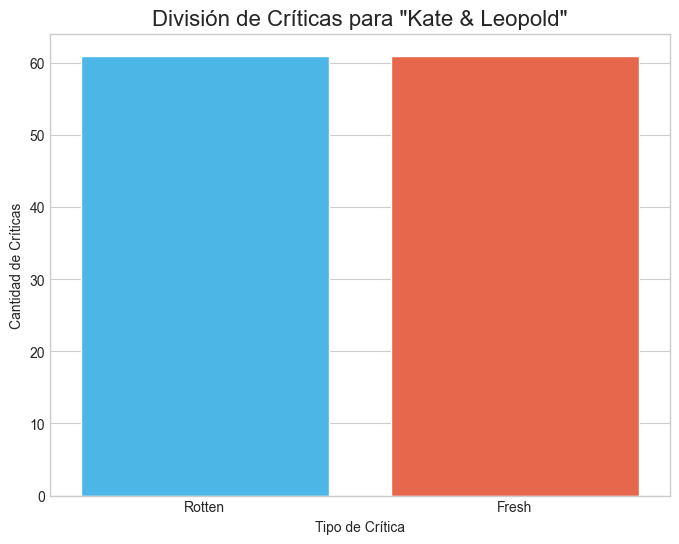

In [ ]:
# Cargar el archivo de películas
df_movies = pd.read_csv('data/rotten_tomatoes_movies.csv')

# Unimos 'df_nlp' y 'df_critics' por el índice.
df_sentiment_link = pd.merge(
    df_nlp[['review_clean', 'sentimiento']],
    df_critics[['rotten_tomatoes_link']],
    left_index=True,
    right_index=True
)

# Unimos con los títulos de las películas
df_merged = pd.merge(
    df_sentiment_link,
    df_movies[['rotten_tomatoes_link', 'movie_title']],
    on='rotten_tomatoes_link'
)

# Calculamos la polarización de las películas
polarization_df = df_merged.groupby(['movie_title', 'rotten_tomatoes_link']).agg(
    sentiment_avg=('sentimiento', 'mean'),
    review_count=('sentimiento', 'count')
).reset_index()

# Calculamos la distancia absoluta desde 0.5 (máxima polarización)
polarization_df['polarization_score'] = abs(polarization_df['sentiment_avg'] - 0.5)

# Filtramos las películas con al menos 50 reseñas, esto asegura que las películas más polarizantes tengan una cantidad significativa de críticas.
min_reviews = 50
polarization_df_filtered = polarization_df[polarization_df['review_count'] >= min_reviews]

# Ordenamos por 'polarization_score' de forma ascendente para encontrar las más cercanas a 0.5
top_polarizing_movies = polarization_df_filtered.sort_values('polarization_score', ascending=True)

# Mostrar los resultados

print(f"--- Top 15 Películas Más Polarizantes (con más de {min_reviews} reseñas) ---")
print(top_polarizing_movies.head(15))

# Visualizar la película más polarizante

# Elige la película más polarizante de la lista (la primera)
top_movie_title = top_polarizing_movies.iloc[0]['movie_title']
top_movie_link = top_polarizing_movies.iloc[0]['rotten_tomatoes_link']

# Filtra las críticas para esa película
movie_reviews = df_merged[df_merged['rotten_tomatoes_link'] == top_movie_link]

# Prepara los datos para el gráfico
review_counts = movie_reviews['sentimiento'].value_counts().rename({1: 'Fresh', 0: 'Rotten'})

# Crea el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=review_counts.index, y=review_counts.values, palette=['#33C1FF', '#FF5733'])
plt.title(f'División de Críticas para "{top_movie_title}"', fontsize=16)
plt.ylabel('Cantidad de Críticas')
plt.xlabel('Tipo de Crítica')
plt.show()


#### ¿Existen géneros que tienden a recibir reseñas más extremas?


Para analizar esto correctamente, si una película pertenece a tres géneros, sus críticas contarán para los tres. El método para lograr esto en pandas se llama `explode`:


Limpiamos y "explotamos" la columna de géneros para que cada género de una película tenga su propia fila.

Agrupamos por cada género individual y calculamos el sentimiento promedio es decir, el porcentaje de 'Fresh'.

Identificamos los géneros cuyo sentimiento promedio esté más cerca de 0.5, indicando la máxima polarización.

In [ ]:
# Unimos el sentimiento con el link de la película.
df_sentiment_link = pd.merge(
    df_nlp[['review_clean', 'sentimiento']],
    df_critics[['rotten_tomatoes_link']],
    left_index=True,
    right_index=True
)

# Unimos con la información de las películas, INCLUYENDO 'genres'.
df_merged = pd.merge(
    df_sentiment_link,
    df_movies[['rotten_tomatoes_link', 'movie_title', 'genres']], # <-- ESTA ES LA LÍNEA CORREGIDA
    on='rotten_tomatoes_link'
)

# Análisis de polarización por género

# Copiamos para no modificar el dataframe original
df_genre = df_merged.copy()

# Eliminamos filas donde el género no está definido
df_genre.dropna(subset=['genres'], inplace=True)

# Convertimos la columna de géneros de un string a una lista de strings
df_genre['genres'] = df_genre['genres'].str.split(', ')

# .explode() crea una fila por cada género en la lista
df_exploded = df_genre.explode('genres')

# Calculamos la polarización por género
genre_polarization = df_exploded.groupby('genres').agg(
    sentiment_avg=('sentimiento', 'mean'),
    review_count=('sentimiento', 'count')
).reset_index()

# Calculamos la distancia desde 0.5
genre_polarization['polarization_score'] = abs(genre_polarization['sentiment_avg'] - 0.5)

# Filtramos y ordenamos
min_reviews_genre = 1000
genre_polarization_filtered = genre_polarization[genre_polarization['review_count'] >= min_reviews_genre]
top_polarizing_genres = genre_polarization_filtered.sort_values('polarization_score', ascending=True)

# Mostramos los resultados
print(f"--- Top 10 Géneros Más Polarizantes (con más de {min_reviews_genre} reseñas) ---")
print(top_polarizing_genres.head(10))

--- Top 10 Géneros Más Polarizantes (con más de 1000 reseñas) ---
                       genres  sentiment_avg  review_count  polarization_score
11                     Horror       0.558699        101160            0.058699
0          Action & Adventure       0.588311        280299            0.088311
5                      Comedy       0.591093        343604            0.091093
14         Mystery & Suspense       0.596639        225917            0.096639
15                    Romance       0.598995        110405            0.098995
16  Science Fiction & Fantasy       0.619198        167759            0.119198
12              Kids & Family       0.629549         77438            0.129549
9        Faith & Spirituality       0.639202          2306            0.139202
20                    Western       0.666544         10904            0.166544
8                       Drama       0.667549        599345            0.167549


Rey de la Polémica: **Horror**

Con un sentimiento promedio de 0.55 (casi un 50/50 perfecto), el Terror se corona como el género más polarizante.
